In [1]:
import mne
from autoreject import AutoReject
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.cluster import ModKMeans
%matplotlib qt 



In [12]:
"""ZAŁADOWANIE SYGNAŁU I USTAWIENIE UKŁADU ELEKTROD"""
d_path = "eeg_files/20241017_kp.bdf" #ścieżka do pliku
ch_eog = ["EXG1","EXG2"] #zdefiniowanie dedykowanych kanałów EOG
ch_ecg = ["EXG3","EXG4"] #zdefiniowanie dedykowanych kanałów ECG
ch_exclude = [f"EXG{i}" for i in range(5,9)] #wykluczenie kanałów niewykorzystanych w badaniu
raw = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw.set_montage("biosemi64")
raw.set_eeg_reference(projection=True)
raw.filter(0.1, 45)
raw.notch_filter(50)
epochs = mne.make_fixed_length_epochs(raw, duration=4, preload=True)
epochs.load_data()

Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequen

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Not setting metadata
357 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 357 events and 8192 original time points ...
0 bad epochs dropped


<Epochs | 357 events (all good), 0 – 4 s (baseline off), ~1.50 GiB, data loaded,
 '1': 357>

In [17]:
"""ZAIMPORTOWANIE PLIKÓW"""
import autoreject
ica_fname = "/Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/best_ica_19.05-ica.fif"
epochs_ar_fname = "/Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/epochs_ar_1.set"
reject_log_filename = "/Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg.npz"
ica = mne.preprocessing.read_ica(ica_fname)
epochs_full = mne.read_epochs_eeglab(epochs_ar_fname)
reject_log = autoreject.read_reject_log(reject_log_filename)
epochs_ica = epochs[~reject_log.bad_epochs]

Reading /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/best_ica_19.05-ica.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
Now restoring ICA solution ...
Ready.
Extracting parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/epochs_ar_1.set...


/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_25310/2448118556.py:7: RuntimeWarning: Estimated head radius (11.4 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs_full = mne.read_epochs_eeglab(epochs_ar_fname)


Not setting metadata
292 matching events found
No baseline correction applied
0 projection items activated
Ready.


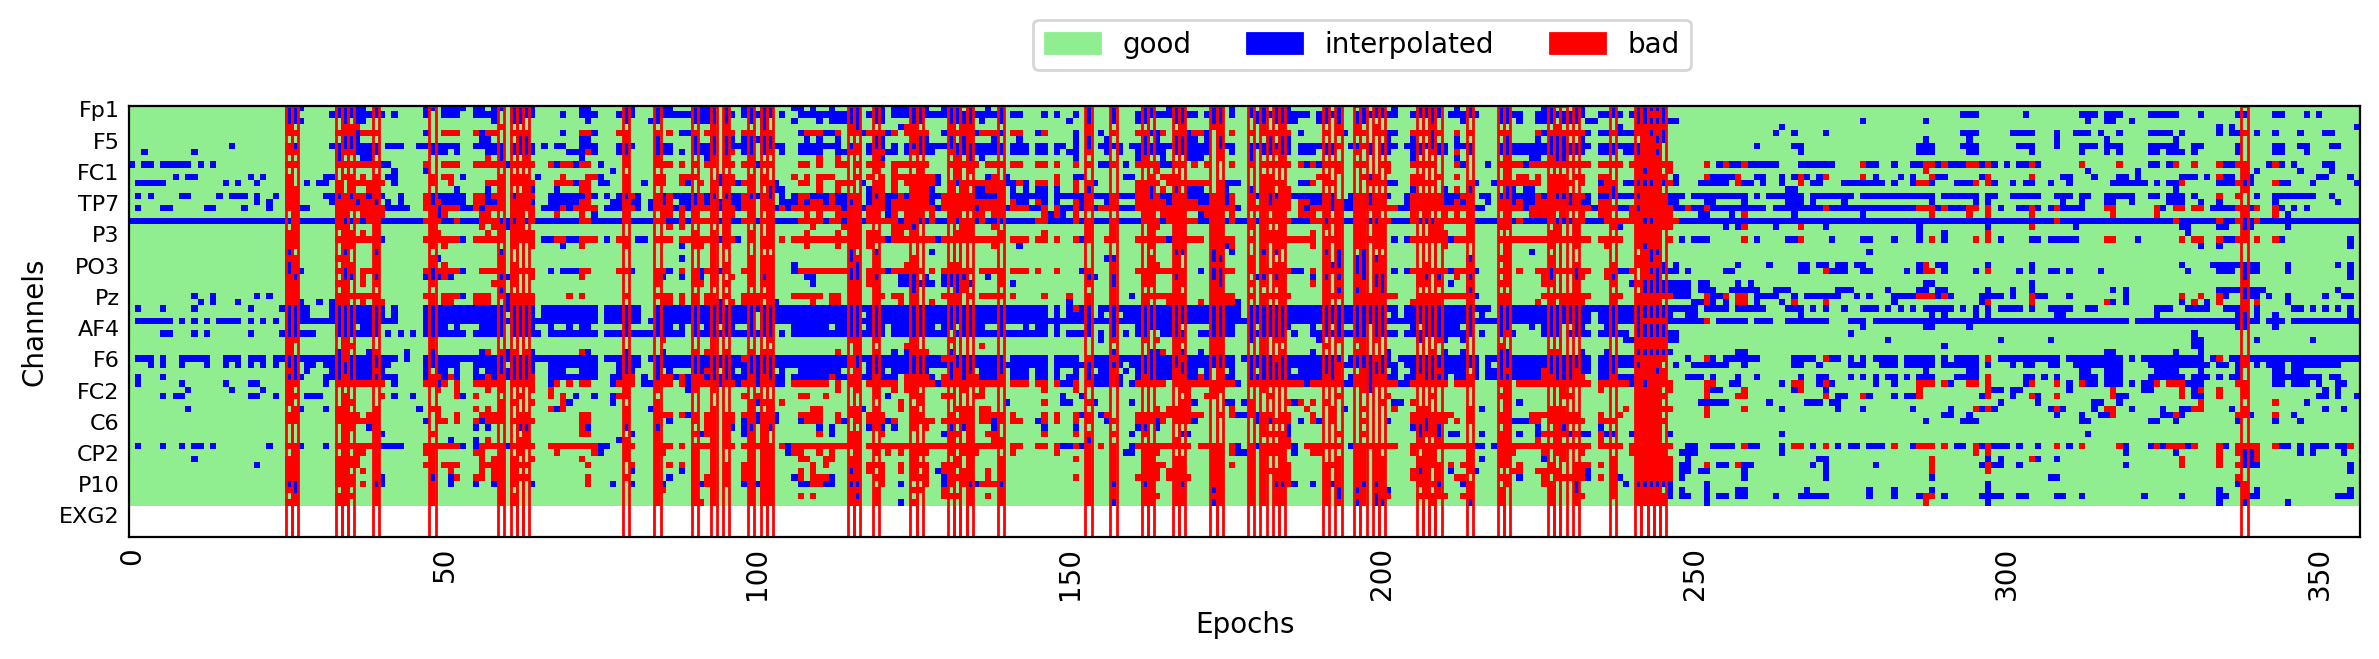

In [16]:
reject_log.plot("horizontal")

In [13]:
epochs_ica = epochs[~reject_log.bad_epochs]

In [45]:
from mne_icalabel import label_components
ic_labels_1 = label_components(epochs_ica, ica, method='iclabel')
labels_1 = ic_labels_1["labels"]

/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_25310/2144831001.py:2: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels_1 = label_components(epochs_ica, ica, method='iclabel')
/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_25310/2144831001.py:2: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels_1 = label_components(epochs_ica, ica, method='iclabel')
/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_25310/2144831001.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was

In [52]:
print(labels_1)
for idx,label in enumerate(labels_1):
    if label == "eye blink":
        print(f"Komponent IC00{idx} sklasyfikowano jako {label} - artefakt wzrokowy")

['eye blink', 'eye blink', 'channel noise', 'channel noise', 'other', 'brain', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'channel noise', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other']
Komponent IC000 sklasyfikowano jako eye blink - artefakt wzrokowy
Komponent IC001 sklasyfikowano jako eye blink - artefakt wzrokowy


In [56]:
print(f"Liczba komponentów zaklasyfikowana jako other: {labels_1.count("other")}")

Liczba komponentów zaklasyfikowana jako other: 53


In [59]:
eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,ch_name=ch_eog)
print(eog_indices)

[np.int64(0)]


In [21]:
print(eog_indices)

[np.int64(0)]


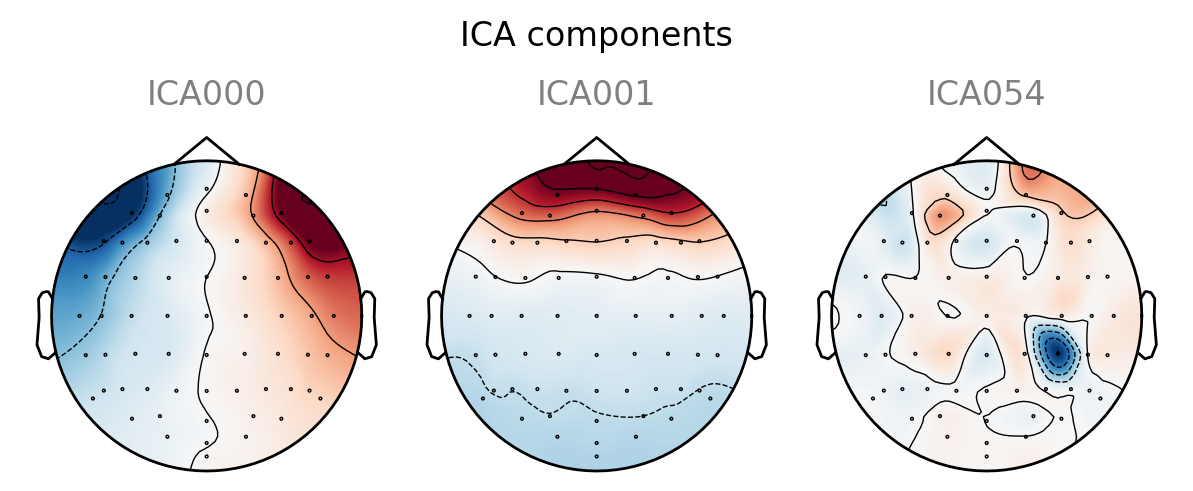

In [22]:
ica.plot_components(picks=[0,1,54])

In [44]:
ica.plot_properties(epochs_full,picks=[0,1])

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [27]:
ica.plot_components()

[<MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1950x1934 with 20 Axes>,
 <MNEFigure size 1170x520 with 3 Axes>]

In [32]:
epochs_cleaned = epochs_ica.copy()

In [37]:
ica.apply(epochs_full,exclude=ica.exclude)


<EpochsEEGLAB | 292 events (all good), 0 – 4 s (baseline off), ~1.23 GiB, data loaded,
 '1': 292>

In [40]:
epochs_full = epochs_ar.copy().pick_types(eeg=True, exclude='bads')
epochs_full.set_eeg_reference("average")

<EpochsEEGLAB | 292 events (all good), 0 – 4 s (baseline off), ~1.23 GiB, data loaded,
 '1': 292>

In [41]:
gfp_data = extract_gfp_peaks(epochs_full, min_peak_distance=3)
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(gfp_data, n_jobs=10, verbose="WARNING")
ModK.plot()

ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
EXG1, EXG2, EXG3, EXG4, Status

Exception ignored in: <function ResourceTracker.__del__ at 0x102f1f4c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107d674c0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi